# Partie II : Simulation des files M/M/c/K

### **Question 2 – Simulation d’une file à capacité finie et serveurs multiples**

On généralise le modèle précédent au cas d’une file **M/M/c/K**, c’est-à-dire :

- Les interarrivées $ Q_k \sim \mathrm{Exp}(\lambda) $
- Les temps de service $ S_k \sim \mathrm{Exp}(\mu) $
- $ c $ serveurs fonctionnant en parallèle
- Capacité maximale $ K $ (clients dans le système, service inclus)
- Discipline **FIFO**

Lorsqu’un client arrive alors que $ N_t = K $, il est **refusé**.

### Travail demandé
1. Implémenter une simulation du processus $ (N_t)_{t \ge 0} $, représentant le nombre de clients dans le système.
2. Compter :
   - Le nombre de clients **acceptés**,
   - Le nombre de clients **refusés** (perdus).
3. Afficher l’évolution temporelle de :
   - $ N_t $ (clients dans le système),
   - $ \max(N_t - c, 0) $ (clients en file d’attente),
   - $ \min(N_t, c) $ (clients en service),
   avec une **ligne rouge horizontale** représentant la capacité $ K $.
4. Calculer et comparer :
   - La **probabilité de refus empirique**,
   - La **probabilité de refus théorique** $ P_{\text{blocage}} = \pi_K $,
   où $ (\pi_n)_{n=0}^K $ est la loi stationnaire du processus de naissance et mort.

### Rappel des taux de transition
$$
\lambda_n = 
\begin{cases}
\lambda, & n < K, \\
0, & n = K,
\end{cases}
\qquad
\mu_n =
\begin{cases}
n \mu, & n \le c, \\
c \mu, & n > c.
\end{cases}
$$

Ce modèle permet de modéliser les systèmes **à capacité limitée**, comme les files de clients avec espace restreint, ou les serveurs réseau à taille de buffer finie.

In [11]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from math import factorial

### Comprendre le module `heapq` dans la simulation M/M/c/K

Dans cette simulation, le module **heapq** de Python est utilisé pour gérer efficacement la liste des **serveurs actuellement occupés**.  

Un **tas** (ou *file de priorité*) est une structure de données qui garde **en première position l’élément le plus petit**.  
Cela permet de savoir **quel serveur terminera son service en premier**, c’est-à-dire celui dont le **temps de départ est le plus proche**.  

Dans le code, la logique est la suivante :  

- `servers = []`  
  Initialise une liste vide qui contiendra les **temps de départ** des serveurs en activité.  

- `heapq.heappush(servers, t_departure)`  
  Ajoute un **nouveau temps de départ** dans le tas, en maintenant automatiquement l’ordre de priorité (le plus petit en premier).  

- `heapq.heappop(servers)`  
  Retire et renvoie le **plus petit temps de départ**, correspondant au **serveur qui vient de se libérer**.  

Ainsi, `heapq` permet de manipuler efficacement les événements de fin de service, sans avoir à trier la liste complète à chaque fois.  
Cette approche assure une complexité temporelle de **O(log n)** par insertion ou suppression, ce qui rend la simulation fluide même pour un grand nombre de clients.


In [12]:
def simulate_arrivals_services_mmck(n_customers, lambda_rate, mu_rate, c, K, random_seed=42):
    """
    Simulate an M/M/c/K queue using event-driven logic (FIFO discipline).
    
    Parameters
    ----------
    n_customers : int
        Number of potential arrivals to simulate (including possible rejections).
    lambda_rate : float
        Arrival rate λ.
    mu_rate : float
        Service rate μ (per server).
    c : int
        Number of servers.
    K : int
        Maximum number of customers in the system (including those in service).
    random_seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    results : dict
        - "T_n" : array of arrival times
        - "S_n" : array of service times (for accepted customers)
        - "D_n" : array of departure times
        - "W_q" : waiting times in queue
        - "W"   : total times in system
        - "accepted" : number of accepted customers
        - "rejected" : number of rejected customers
        - "times"    : list of event times
        - "clients"  : list of N_t (system size evolution)
    """
    np.random.seed(random_seed)

    # --- Generate interarrival and service times ---
    Q = np.random.exponential(1/lambda_rate, n_customers)  # Interarrival times
    S = np.random.exponential(1/mu_rate, n_customers)  # Service times
    T = np.cumsum(Q)  # Arrival times

    # --- Initialize ---
    servers = []  # min-heap of departure times of busy servers
    D = []        # departure times (accepted customers)
    Wq, W = [], []
    N_t, times = [], []

    accepted = 0
    rejected = 0

    for i in range(n_customers):
        t_arrival = T[i]

        # Remove finished services before t_arrival
        while servers and servers[0] <= t_arrival:
            heapq.heappop(servers)
            times.append(t_arrival)
            N_t.append(len(servers))

        n_system = len(servers)
        if n_system < K:
            # Customer accepted
            accepted += 1

            if n_system < c:
                # Starts service immediately
                t_service_start = t_arrival
                t_departure = t_service_start + S[i]
                Wq.append(0.0)
            else:
                # Wait for the earliest free server
                t_service_start = servers[0]
                t_departure = t_service_start + S[i]
                Wq.append(t_service_start - t_arrival)

            W.append(t_departure - t_arrival)
            D.append(t_departure)

            # Add to heap of busy servers
            heapq.heappush(servers, t_departure)
        else:
            # Customer rejected
            rejected += 1

        # Track evolution (after each event)
        times.append(t_arrival)
        N_t.append(len(servers))

    # Convert to arrays
    return {
        "T_n": np.array(T[:accepted]),
        "S_n": np.array(S[:accepted]),
        "D_n": np.array(D),
        "W_q": np.array(Wq),
        "W": np.array(W),
        "accepted": accepted,
        "rejected": rejected,
        "times": np.array(times),
        "clients": np.array(N_t)
    }

In [13]:
# ===============================================================
# Compute theoretical performance metrics for an M/M/c/K queue
# ===============================================================
def compute_mmck_metrics(lambda_rate, mu_rate, c, K):
    """
    Compute theoretical metrics for an M/M/c/K queue.
    
    Parameters
    ----------
    lambda_rate : float
        Arrival rate λ.
    mu_rate : float
        Service rate μ.
    c : int
        Number of servers.
    K : int
        System capacity (including customers in service).
    
    Returns
    -------
    metrics : dict
        Dictionary with theoretical values:
        - rho  : traffic intensity
        - Pk   : blocking probability
        - L    : expected number in system
        - Lq   : expected number in queue
        - W    : expected time in system
        - Wq   : expected waiting time
    """
    rho = lambda_rate / (c * mu_rate)
    
    # Compute normalization constant
    sum_terms = 0.0
    sum_tail = 0.0
    P0 = 0.0
    
    # Stationary probabilities
    pi = np.zeros(K + 1)
    for n in range(K + 1):
        if n < c:
            pi[n] = ((c * rho)**n / np.math.factorial(n)) * P0
        else:
            pi[n] = ((c * rho)**c / np.math.factorial(c)) * rho**(n - c) * P0

    Pk = pi[K]
    
    # Effective arrival rate
    lambda_eff = lambda_rate * (1 - Pk)
    
    # Mean number in system
    L = sum(n * pi[n] for n in range(K + 1))
    
    # Mean number in queue
    Lq = sum(n * pi[n] for n in range(c, K + 1))

    # By Little's Law
    W = L / lambda_eff if lambda_eff > 0 else 0
    Wq = Lq / lambda_eff if lambda_eff > 0 else 0

    return {"rho": rho, "Pk": Pk, "L": L, "Lq": Lq, "W": W, "Wq": Wq, "pi": pi}

In [14]:
def theoretical_pi_mmck(lambda_, mu, c, K):
    """
    Compute the stationary distribution π_n for an M/M/c/K queue.

    Parameters
    ----------
    lambda_ : float
        Arrival rate (λ)
    mu : float
        Service rate (μ)
    c : int
        Number of servers
    K : int
        System capacity (including those in service)

    Returns
    -------
    pi : np.ndarray
        Stationary distribution π_n for n = 0,...,K
    """
    rho = lambda_ / mu
    pi = np.zeros(K + 1)
    norm = 0.0

    for n in range(K + 1):
        if n < c:
            term = rho**n / factorial(n)
        else:
            term = rho**n / (factorial(c) * c**(n - c))
        norm += term

    pi[0] = 1 / norm

    for n in range(1, K + 1):
        if n < c:
            pi[n] = (rho**n / factorial(n)) * pi[0]
        else:
            pi[n] = (rho**n / (factorial(c) * c**(n - c))) * pi[0]

    return pi

In [15]:
def compare_empirical_theoretical(results, lambda_, mu, c, K):
    """
    Compare empirical occupancy statistics with the theoretical stationary distribution π_n.
    Display a formatted table of comparison metrics.
    """
    times, clients = results["times"], results["clients"]
    pi = theoretical_pi_mmck(lambda_, mu, c, K)
    empirical_dist, _ = np.histogram(clients, bins=np.arange(K + 2), density=True)

    # --- Compute theoretical expectations ---
    n_vals = np.arange(K + 1)
    L_theo = np.sum(n_vals * pi)                 # E[N_t]
    rho_theo = (lambda_ / (c * mu)) * (1 - pi[K])  # Utilization (approx)
    W_theo = L_theo / (lambda_ * (1 - pi[K]))    # Little's law (effective λ)
    Wq_theo = W_theo - 1 / mu                    # Expected waiting time in queue

    # --- Empirical statistics ---
    L_emp = np.sum(n_vals * empirical_dist)
    rho_emp = min(L_emp / c, 1.0)
    W_emp = np.mean(results["W"]) if len(results["W"]) > 0 else np.nan
    Wq_emp = np.mean(results["W_q"]) if len(results["W_q"]) > 0 else np.nan

    theoretical = {"rho": rho_theo, "L": L_theo, "W": W_theo, "Wq": Wq_theo}
    empirical = {"rho": rho_emp, "L": L_emp, "W": W_emp, "Wq": Wq_emp}

    # --- Display comparison table ---
    print("\n--- Comparison: Empirical vs. Theoretical ---")
    print(f"{'Metric':<8} {'Empirical':>12} {'Theoretical':>15} {'Rel. Error':>15}")
    print("-" * 55)
    for key in ["rho", "L", "W", "Wq"]:
        emp_val = empirical[key]
        theo_val = theoretical[key]
        rel_error = abs(emp_val - theo_val) / theo_val if theo_val != 0 else np.nan
        print(f"{key:<8} {emp_val:>12.4f} {theo_val:>15.4f} {rel_error:>15.3f}")

    # --- Distribution plot ---
    plt.figure(figsize=(8,4))
    plt.bar(range(K+1), pi, color="skyblue", edgecolor='k', label=r"Theoretical $\pi_n$")
    plt.bar(range(K+1), empirical_dist, color="orange", alpha=0.6, label="Empirical")
    plt.title(fr"Stationary distribution — M/M/{c}/{K}")
    plt.xlabel(r"$n$ (number of clients in system)")
    plt.ylabel(r"$\pi_n$")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

In [16]:
def visualize_trajectories(results, lambda_, mu, c, K):
    """
    Visualize the temporal evolution of the number of clients in an M/M/c/K queue.
    """
    times, clients = results["times"], results["clients"]
    n_queue = np.maximum(clients - c, 0)
    n_service = np.minimum(clients, c)

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # (1) Total clients in system
    axs[0].step(times, clients, where="post", label=r"$N_t$ — Clients dans le système")
    axs[0].axhline(y=K, color="r", linestyle="--", label=fr"Capacité $K={K}$")
    axs[0].legend()
    axs[0].set_ylabel(r"$N_t$")
    axs[0].grid(True, linestyle="--", alpha=0.6)

    # (2) Clients waiting (not in service)
    axs[1].step(times, n_queue, where="post", color="orange", label=r"$N_t - c$ (en attente)")
    axs[1].axhline(y=K - c, color="blue", linestyle="--", alpha=0.5, label=fr"Nbr max de clients en attente ${K-c}$")
    axs[1].set_ylim(-0.3, axs[0].get_ylim()[1])
    axs[1].legend()
    axs[1].set_ylabel(r"File ($\max(N_t - c, 0)$)")
    axs[1].grid(True, linestyle="--", alpha=0.6)

    # (3) Clients in service
    axs[2].step(times, n_service, where="post", color="green", label=r"Clients servis ($\min(N_t, c)$)")
    axs[2].axhline(y=c, color="purple", linestyle="--", alpha=0.5, label=fr"Serveurs $c={c}$")
    axs[2].legend()
    axs[2].set_ylabel(r"Service")
    axs[2].set_xlabel("Temps")
    axs[2].grid(True, linestyle="--", alpha=0.6)

    plt.suptitle(fr"Évolution temporelle — File $M/M/{c}/{K}$  ($\lambda={lambda_}$, $\mu={mu}$, $c={c}$)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [17]:
# --- Parameters ---
lambda_ = 4     # arrival rate
mu = 3          # service rate per server
c = 2           # number of servers
K = 6           # max capacity (service + queue)
T_max = 1000      # total simulation time (approximate)
n_customers = int(lambda_ * T_max * 2)  # simulate roughly twice expected arrivals

# --- Simulation ---
results = simulate_arrivals_services_mmck(n_customers, lambda_, mu, c, K, random_seed=123)

# Extract relevant data
times = results["times"]
clients = results["clients"]
refusals = results["rejected"]
accepted = results["accepted"]

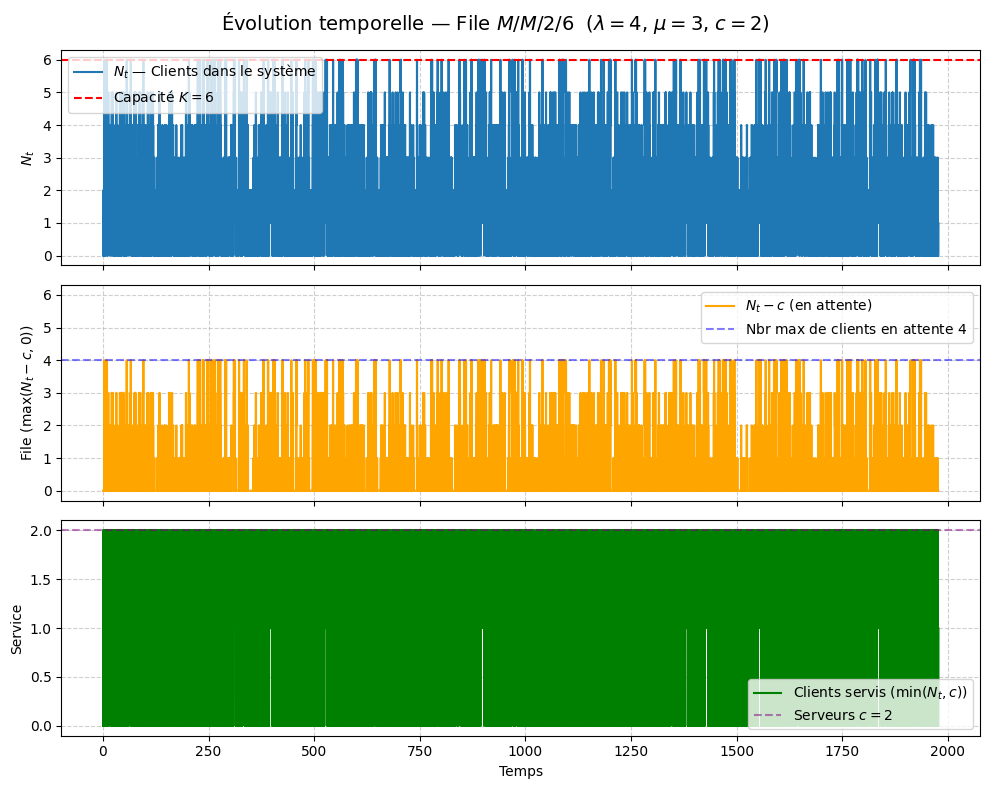

In [18]:
visualize_trajectories(results, lambda_, mu, c, K)

In [19]:
# --- Empirical statistics ---
lambda_eff = lambda_ * (1 - refusals / (lambda_ * T_max))
print(f"Effective arrival rate λ_eff ≈ {lambda_eff:.3f}")
print(f"Number of accepted customers: {accepted}")
print(f"Number of refusals: {refusals}")
print(f"Proportion refused ≈ {refusals / (lambda_ * T_max):.3%}")

Effective arrival rate λ_eff ≈ 3.881
Number of accepted customers: 7881
Number of refusals: 119
Proportion refused ≈ 2.975%



--- Comparison: Empirical vs. Theoretical ---
Metric      Empirical     Theoretical      Rel. Error
-------------------------------------------------------
rho            1.0000          0.6415           0.559
L              2.0595          1.9014           0.083
W              0.3970          0.4940           0.196
Wq             0.0646          0.1607           0.598


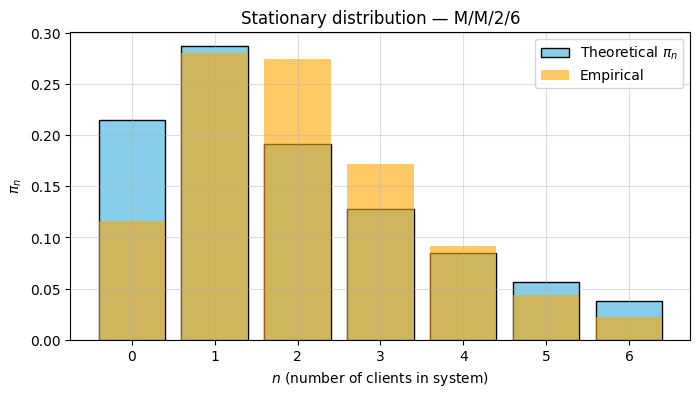

In [20]:
import numpy as np
# --- Visualization and comparison ---
compare_empirical_theoretical(results, lambda_, mu, c, K)